In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [2]:
#Loading the dataset
df = pd.read_csv("diabetes_prediction_Dataset.csv")

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
#Checking for missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

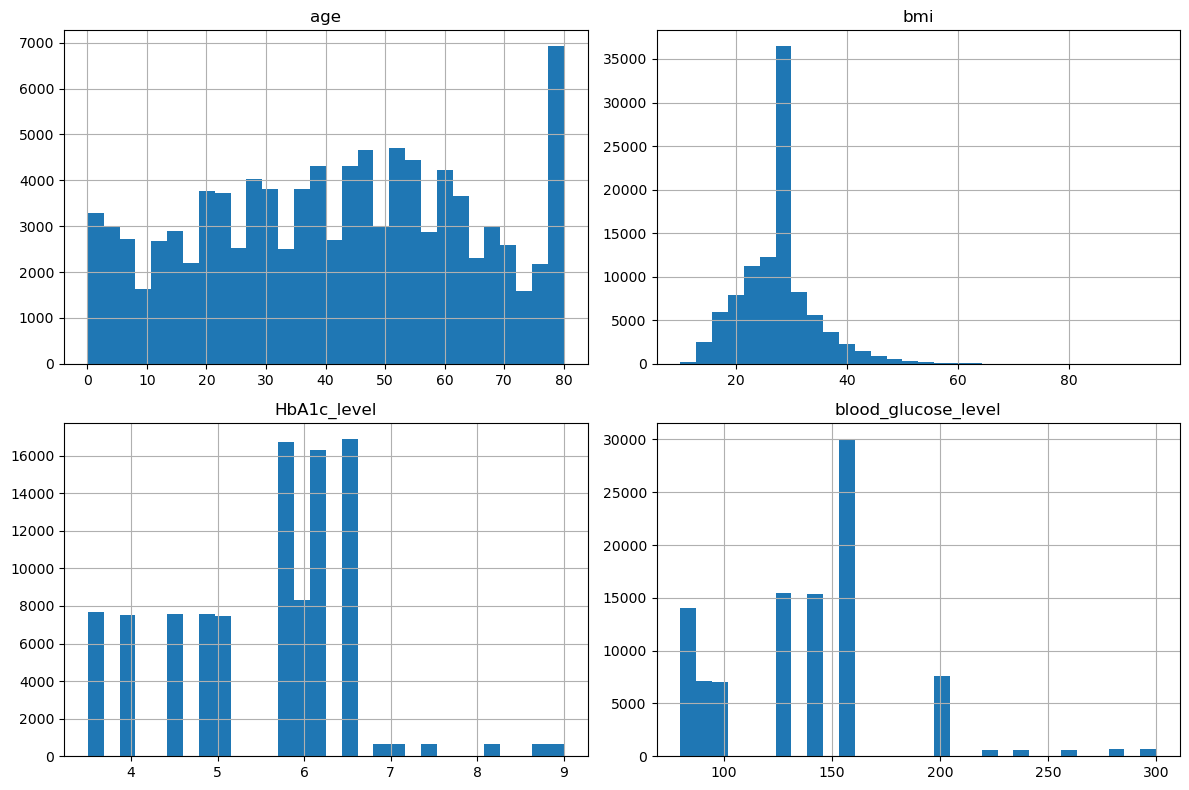

In [7]:
#Checking for outliers, skewed distributions
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
df[numerical_cols].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

<Axes: xlabel='gender', ylabel='count'>

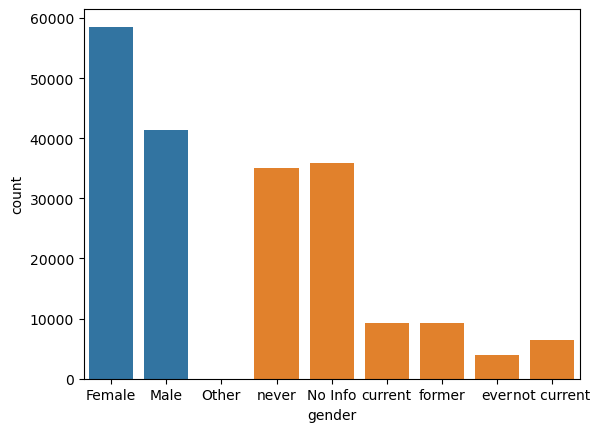

In [8]:
#Cheching dominant categories, rare values
sns.countplot(x='gender', data=df)
sns.countplot(x='smoking_history', data=df)

In [9]:
#Regrouping thr 'smoking_history' column
def smoking_grouping(val):
    if val == 'never':
        return 'never'
    elif val in ['former', 'not current']:
        return 'past'
    elif val == 'current':
        return 'current'
    elif val == 'ever':
        return 'past'  
    else:
        return 'unknown'

In [10]:
df['smoking_history_cleaned'] = df['smoking_history'].apply(smoking_grouping)

<Axes: xlabel='gender', ylabel='count'>

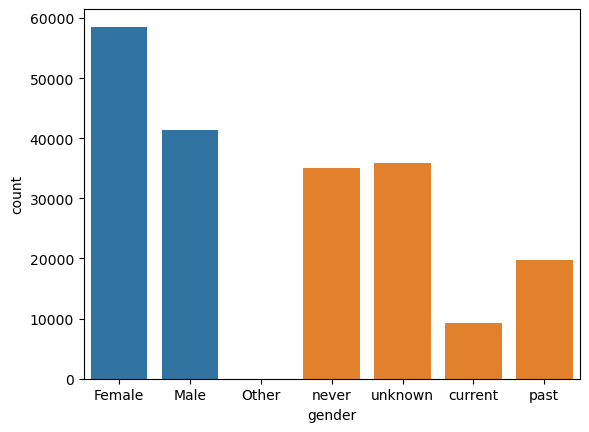

In [11]:
#Cheching dominant categories, rare values
sns.countplot(x='gender', data=df)
sns.countplot(x='smoking_history_cleaned', data=df)

In [12]:
#Dropping the 'smoking_history' column
df = df.drop(columns='smoking_history', axis=1)

In [13]:
#Converting 'age' column to integer
df['age'] = df['age'].astype(int)

In [14]:
#Checking for class imbalance
df['diabetes'].value_counts(normalize=True)

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

In [15]:
#Checking corrrelation
cols = ['age', 'hypertension', 'HbA1c_level', 'bmi', 'diabetes']
df[cols].corr()

,age,hypertension,HbA1c_level,bmi,diabetes
age,1.000000,0.251093,0.101328,0.337747,0.257933
hypertension,0.251093,1.000000,0.080939,0.147666,0.197823
HbA1c_level,0.101328,0.080939,1.000000,0.082997,0.400660
bmi,0.337747,0.147666,0.082997,1.000000,0.214357
diabetes,0.257933,0.197823,0.400660,0.214357,1.000000


In [16]:
#Splitting the data set into Target and Features
X = df.drop(columns='diabetes', axis=1)
y = df['diabetes']

In [17]:
#Splitting into testing and trainig data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [18]:
#Categorical columns
cat_columns = list(X.select_dtypes(['object', 'category']).columns)

In [19]:
#Numeric columns
num_columns = list(X.select_dtypes(['int64', 'float64']).columns)

In [20]:
cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

In [21]:
num_pipeline = Pipeline([
    ('ss', StandardScaler())
])

In [22]:
preprocessor = ColumnTransformer(transformers=[("num", num_pipeline, num_columns),
                                               ("cat", cat_pipeline, cat_columns)])

In [23]:
#Applying cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

In [25]:
#Random Forest Classifier pipeline
pipeline_rfc = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('rfc', RandomForestClassifier())
])

In [26]:
params = {
    'rfc__n_estimators': range(10, 100, 10),
    'rfc__max_depth': range(10, 50, 10)
}

In [27]:
#Random Forest Classifier Hyper-parameter tuning
model_rfc = GridSearchCV(
    pipeline_rfc,
    param_grid = params,
    cv = cv,
    n_jobs = 5, 
    verbose = 1
)

In [29]:
#Training the Random Forest Classifier
model_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'bmi',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'smoking_history_cleaned'])])),
                                       ('smote', SMOTE()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'rfc__max_depth': range(10, 50, 10),
                         'rfc__n_estimators': range(10, 100, 10)},
             verbose=1)

In [32]:
model_rfc.score(X_train, y_train)

0.9989875

In [34]:
y_pred_rfc = model_rfc.predict(X_test)

In [35]:
#Random Forest classification report
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18332
           1       0.76      0.76      0.76      1668

    accuracy                           0.96     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.96      0.96      0.96     20000



In [38]:
#Random forest confusion matrix
print(confusion_matrix(y_test, y_pred_rfc))

[[17934   398]
 [  399  1269]]


In [39]:
#Best Random forest classier
best_rfc_model = model_rfc.best_estimator_
preprocessor_transformer = best_rfc_model.named_steps['preprocessor']

In [40]:
rfc_estimator = best_rfc_model.named_steps['rfc']
importances_rfc = rfc_estimator.feature_importances_
transformed_feature_names = preprocessor_transformer.get_feature_names_out()
feat_importance_rfc = pd.Series(importances_rfc, index=transformed_feature_names).sort_values()

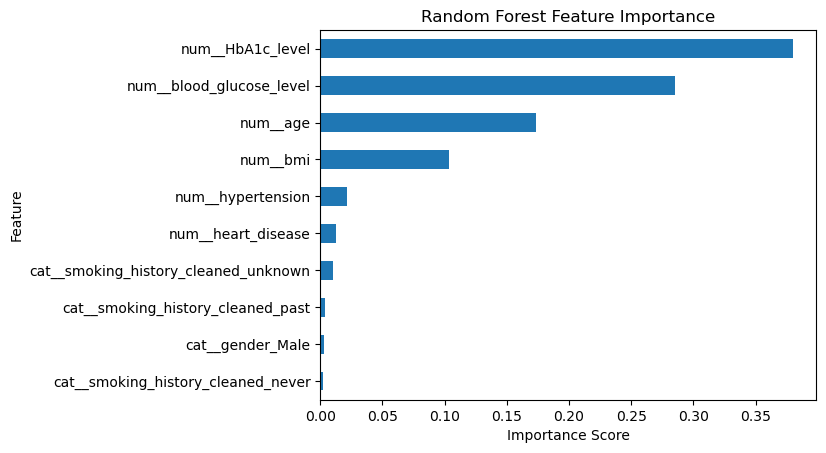

In [41]:
#Plotting the random forst classifier feature importance
feat_importance_rfc.tail(10).plot(kind='barh')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

In [42]:
# XGB Classifier Model Pipeline
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=30)),
    ("xgb", XGBClassifier(random_state=30))
])

In [43]:
# XGB Classifier Model Hperparamters
params_xgb = {
    'xgb__max_depth': [10, 50, 10],
    'xgb__n_estimators': [10, 25, 5],
    'xgb__learning_rate': [0.1],
    'xgb__tree_method': ['hist'],
    'xgb__n_jobs': [-1]
}

In [44]:
# XGB Classifier Hyperparameter tuning
model_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=params_xgb,
    cv=cv,
    n_jobs=5,
    verbose=1
)

In [45]:
# Training the XGB Classifier model
model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'hypertension',
                                                                          'heart_disease',
                                                                          'bmi',
                                                                          'HbA1c_level',
                                                                          'blood_glucose_level']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=5,
             param_grid={'xgb__learning_rate': [0.1],
                         'xgb__max_depth': [10, 50, 10],
                         'xgb__n_estimators': [10, 25, 5], 'xgb__n_jobs': [-1],
                         'xgb__tree_method': ['hist']},
             verbose=1)

In [46]:
model_xgb.score(X_train, y_train)

0.9926125

In [47]:
y_pred_xgb = model_xgb.predict(X_test)

In [48]:
# XGB Classifier model classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18332
           1       0.79      0.75      0.77      1668

    accuracy                           0.96     20000
   macro avg       0.88      0.86      0.87     20000
weighted avg       0.96      0.96      0.96     20000



In [49]:
# XGB Classifier model confusion matrix
print(confusion_matrix(y_test, y_pred_xgb))

[[17999   333]
 [  425  1243]]


In [50]:
# Best XGB Classier
best_xgb_model = model_xgb.best_estimator_
preprocessor_transformer_xgb = best_xgb_model.named_steps['preprocessor']

In [51]:
xgb_estimator = best_xgb_model.named_steps['xgb']
importances_xgb = xgb_estimator.feature_importances_
transformed_feature_names_xgb = preprocessor_transformer_xgb.get_feature_names_out()
feat_importance_xgb = pd.Series(importances_xgb, index=transformed_feature_names_xgb).sort_values()

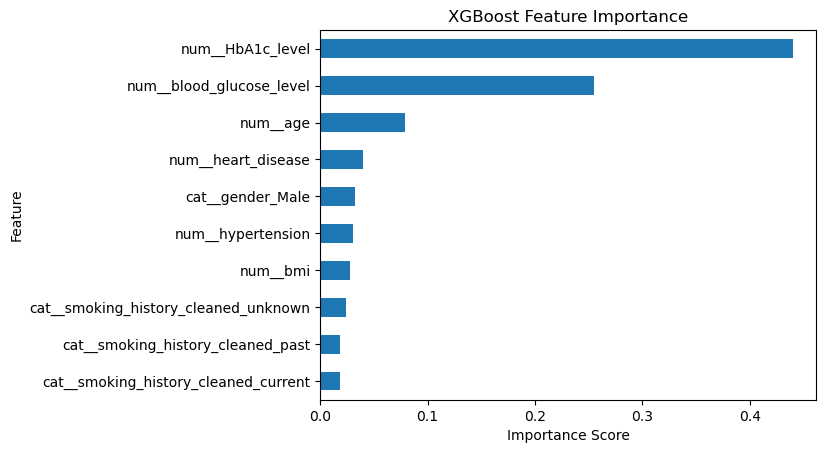

In [52]:
#Plotting the XGB Classifier feature importance
feat_importance_xgb.tail(10).plot(kind='barh')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

In [53]:
import joblib

In [54]:
joblib.dump(best_rfc_model, "diabetes_prediction_rfc.pkl")

['diabetes_prediction_rfc.pkl']